In [22]:
# load_data.py
import pandas as pd

# 从文件加载DataFrame
data = pd.read_pickle('data.pkl')
display(data.head())
print(data.dtypes)


,age,gender,education,marital_status,income,recent_accident,family_accident,witnessed_injury,witnessed_corpse,traumatic_scene,psychiatric_history,medication,smoking,alcohol,pcl_scores,resilience,bmi
0,23,1,3,1,1,1,1,1,1,1,1,1,1,1,0,10,23.781213
1,21,1,2,1,4,1,1,1,1,1,1,1,2,1,20,20,27.335640
2,23,1,1,1,2,2,1,1,1,1,1,1,2,1,0,10,22.491349
3,32,1,2,2,1,1,1,1,1,1,1,1,2,1,16,30,22.204082
4,23,1,1,1,1,1,1,1,1,1,1,1,1,1,0,50,20.761246


age                       int64
gender                 category
education              category
marital_status         category
income                 category
recent_accident        category
family_accident        category
witnessed_injury       category
witnessed_corpse       category
traumatic_scene        category
psychiatric_history    category
medication             category
smoking                category
alcohol                category
pcl_scores                int64
resilience                int64
bmi                     float64
dtype: object


In [23]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib

# 假设 data 已经定义好
X = data.drop('pcl_scores', axis=1)
y = data['pcl_scores']

# 特征分类
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
ordinal_cols = ['education', 'income']  # 根据实际数据调整
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

# 预处理管道
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('ord', OrdinalEncoder(), ordinal_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
                 list(set(categorical_cols) - set(ordinal_cols)))
    ]
)

# 根据提供的最佳参数构建模型
# R参数到Python参数的转换：
# num.trees -> n_estimators = 495
# mtry.ratio -> max_features = 0.540881 (比例)
# min.node.size -> min_samples_leaf = 42
# num.threads -> n_jobs = 1
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=495,
        max_features=0.540881,
        min_samples_leaf=42,
        n_jobs=1,
        random_state=42
    ))
])

# 在整个数据集上训练最终模型
print("正在训练最终模型...")
final_model = final_pipeline.fit(X, y)

# 计算训练集上的预测值
y_pred = final_model.predict(X)

# 计算RMSE和MAE
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)

print(f"训练集RMSE: {rmse:.3f}")
print(f"训练集MAE: {mae:.3f}")

# 保存模型
joblib.dump(final_model, 'final_random_forest_model.pkl')
print("最终模型已保存为 final_random_forest_model.pkl")

正在训练最终模型...
训练集RMSE: 4.914
训练集MAE: 1.999
最终模型已保存为 final_random_forest_model.pkl


In [24]:
# 10. 获取处理后的特征数量
preprocessor = final_model.named_steps['preprocessor']
X_processed = preprocessor.transform(X)

# 获取原始特征名称
original_feature_names = list(X.columns)
processed_feature_names = None

# 尝试获取处理后的特征名称
try:
    num_features = list(numeric_cols)
    ord_features = list(ordinal_cols)
    cat_features = [col for col in categorical_cols if col not in ordinal_cols]
    cat_transformer = preprocessor.named_transformers_['cat']
    cat_feature_names = cat_transformer.get_feature_names_out(cat_features)
    processed_feature_names = num_features + ord_features + list(cat_feature_names)
except:
    # 如果无法获取，使用默认名称
    processed_feature_names = [f'feature_{i}' for i in range(X_processed.shape[1])]






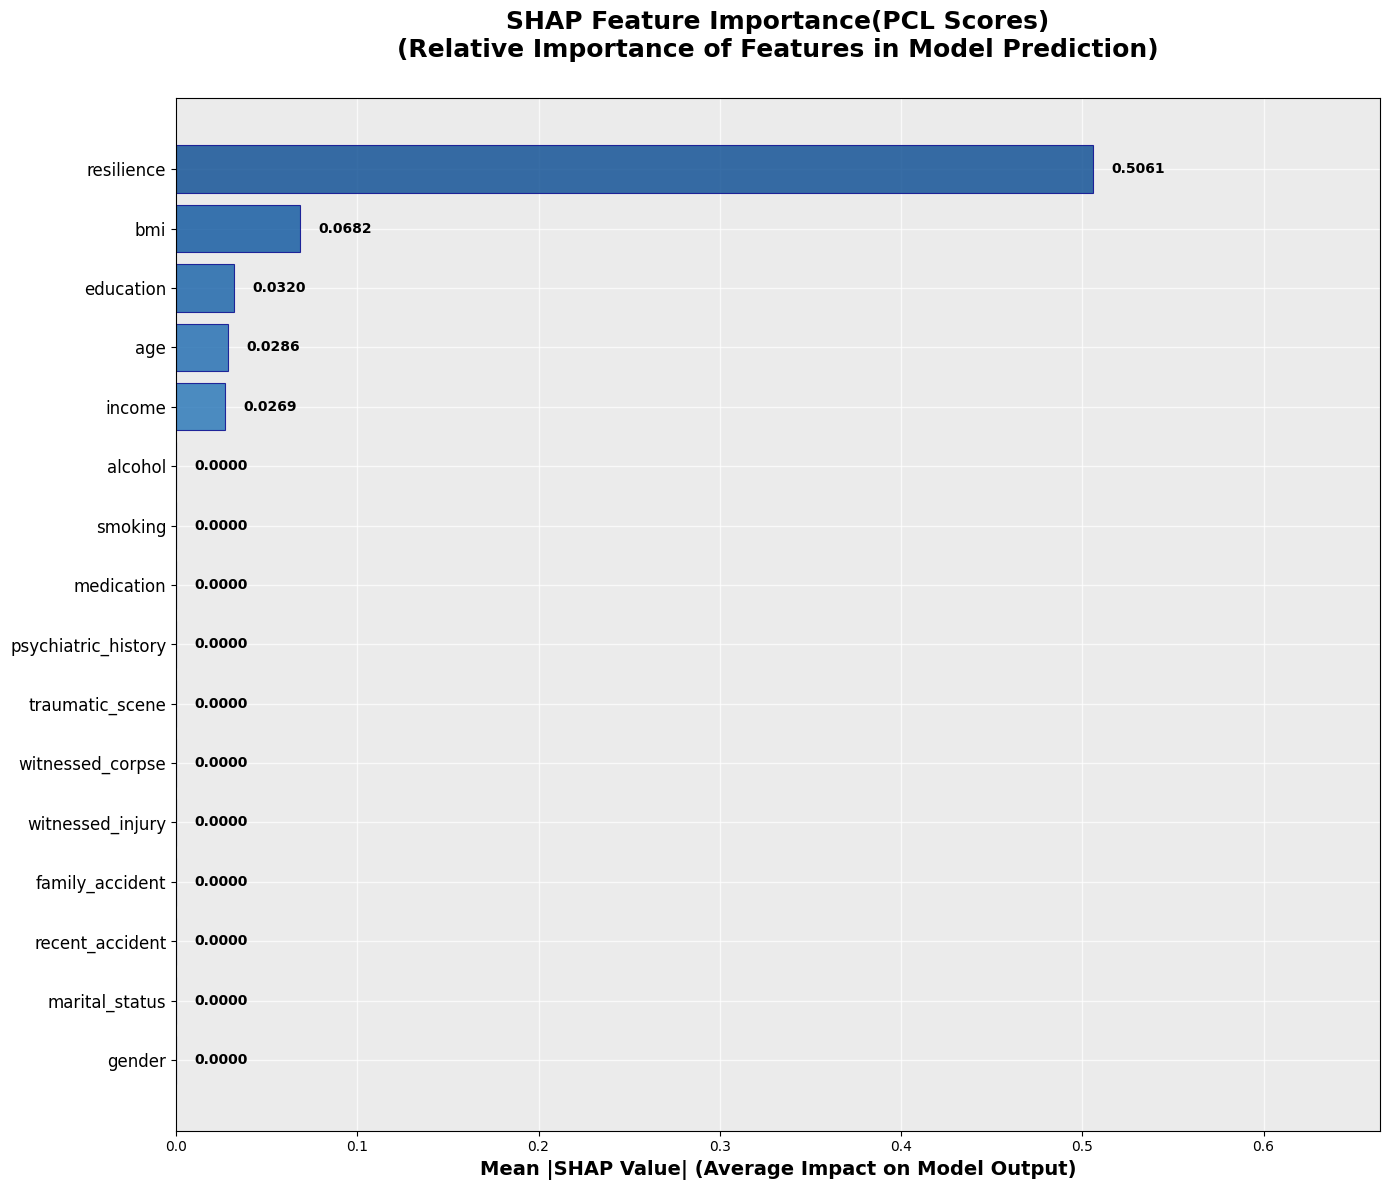

In [35]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

rf_model = final_model.named_steps['regressor']
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_processed)

# 处理shap_values的格式
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# 创建原始特征到处理后特征的映射
def create_feature_mapping(original_features, processed_features, numeric_cols, ordinal_cols, categorical_cols):
    """
    创建原始特征到处理后特征的映射关系
    """
    feature_mapping = {}
    processed_idx = 0
    
    # 数值特征（1对1映射）
    for feature in numeric_cols:
        feature_mapping[feature] = [processed_idx]
        processed_idx += 1
    
    # 有序特征（1对1映射）
    for feature in ordinal_cols:
        feature_mapping[feature] = [processed_idx]
        processed_idx += 1
    
    # 分类特征（1对多映射）
    cat_features = [col for col in categorical_cols if col not in ordinal_cols]
    for feature in cat_features:
        # 找到所有以该特征名开头的处理后特征
        related_indices = []
        for i, proc_feature in enumerate(processed_features[processed_idx:]):
            if proc_feature.startswith(feature + '_'):
                related_indices.append(processed_idx + i)
        if related_indices:
            feature_mapping[feature] = related_indices
            processed_idx = max(related_indices) + 1
        else:
            # 如果没有找到匹配的one-hot特征，可能是单个特征
            feature_mapping[feature] = [processed_idx]
            processed_idx += 1
    
    return feature_mapping

# 创建特征映射
feature_mapping = create_feature_mapping(
    original_feature_names, 
    processed_feature_names, 
    numeric_cols, 
    ordinal_cols, 
    categorical_cols
)

# 合并SHAP值：将one-hot编码特征的SHAP值合并
def aggregate_shap_values(shap_values, feature_mapping, original_feature_names):
    """
    将处理后的SHAP值合并回原始特征
    """
    n_samples = shap_values.shape[0]
    aggregated_shap = np.zeros((n_samples, len(original_feature_names)))
    
    for i, feature in enumerate(original_feature_names):
        if feature in feature_mapping:
            indices = feature_mapping[feature]
            # 对于分类特征，合并其所有one-hot编码特征的SHAP值（取绝对值之和）
            aggregated_shap[:, i] = np.sum(np.abs(shap_values[:, indices]), axis=1)
    
    return aggregated_shap

# 合并SHAP值
aggregated_shap_values = aggregate_shap_values(shap_values, feature_mapping, original_feature_names)

# 创建用于显示的原始特征名称
display_feature_names = original_feature_names

# 关闭所有已存在的图形
plt.close('all')

# 计算特征重要性并排序
feature_importance = np.mean(np.abs(aggregated_shap_values), axis=0)
sorted_idx = np.argsort(feature_importance)[::-1]

# 创建基于蓝色的渐变颜色映射（颜色越深表示越重要）
n_features = len(display_feature_names)
colors = plt.cm.Blues(np.linspace(0.3, 0.9, n_features))  # 从浅蓝(0.3)到深蓝(0.9)

# 创建美化后的SHAP特征重要性图
fig, ax = plt.subplots(figsize=(14, 12))

# 设置灰色背景，类似ggplot2默认样式
ax.set_facecolor('#EBEBEB')  # 浅灰色背景
fig.patch.set_facecolor('white')  # 图形背景为白色

# 绘制水平条形图，最重要的特征用最深的蓝色
bars = ax.barh(range(len(display_feature_names)), 
               feature_importance[sorted_idx], 
               color=colors[::-1],  # 反转颜色顺序，使最重要的特征在顶部且颜色最深
               alpha=0.8,
               edgecolor='darkblue',
               linewidth=0.8)

# 设置y轴标签
ax.set_yticks(range(len(display_feature_names)))
ax.set_yticklabels([display_feature_names[i] for i in sorted_idx], fontsize=12)

# 设置x轴标签
ax.set_xlabel('Mean |SHAP Value| (Average Impact on Model Output)', fontsize=14, fontweight='bold')

# 设置标题
ax.set_title('SHAP Feature Importance(PCL Scores)\n(Relative Importance of Features in Model Prediction)', 
             fontsize=18, fontweight='bold', pad=30)

# 添加网格线 - 类似ggplot2样式
ax.grid(axis='x', alpha=0.7, linestyle='-', color='white', linewidth=1)
ax.grid(axis='y', alpha=0.7, linestyle='-', color='white', linewidth=1)
ax.set_axisbelow(True)

# 计算所有标签的最大宽度，用于确定标签位置
max_value = max(feature_importance)

# 所有标签都显示在条形图右侧
for i, (idx, value) in enumerate(zip(sorted_idx, feature_importance[sorted_idx])):
    # 统一将所有标签放在条形图外部右侧
    ax.text(value + max_value * 0.02, i, 
            f'{value:.4f}', 
            va='center', ha='left', fontsize=10, fontweight='bold', color='black')

# 反转y轴，使最重要的特征在顶部
ax.invert_yaxis()

# 调整x轴限制，为右侧标签留出充足空间
current_xlim = ax.get_xlim()
ax.set_xlim(current_xlim[0], current_xlim[1] * 1.25)

# 调整布局
plt.tight_layout()

plt.savefig('shap_importance_original_features.pdf', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()
plt.close()



置换特征重要性从R代码中获取,记得修改我们的变量名称,两个版本中数据框的变量命名不同.同时用于讨论交互效应的图也可以从那里获取,Python只处理SHAP部分.

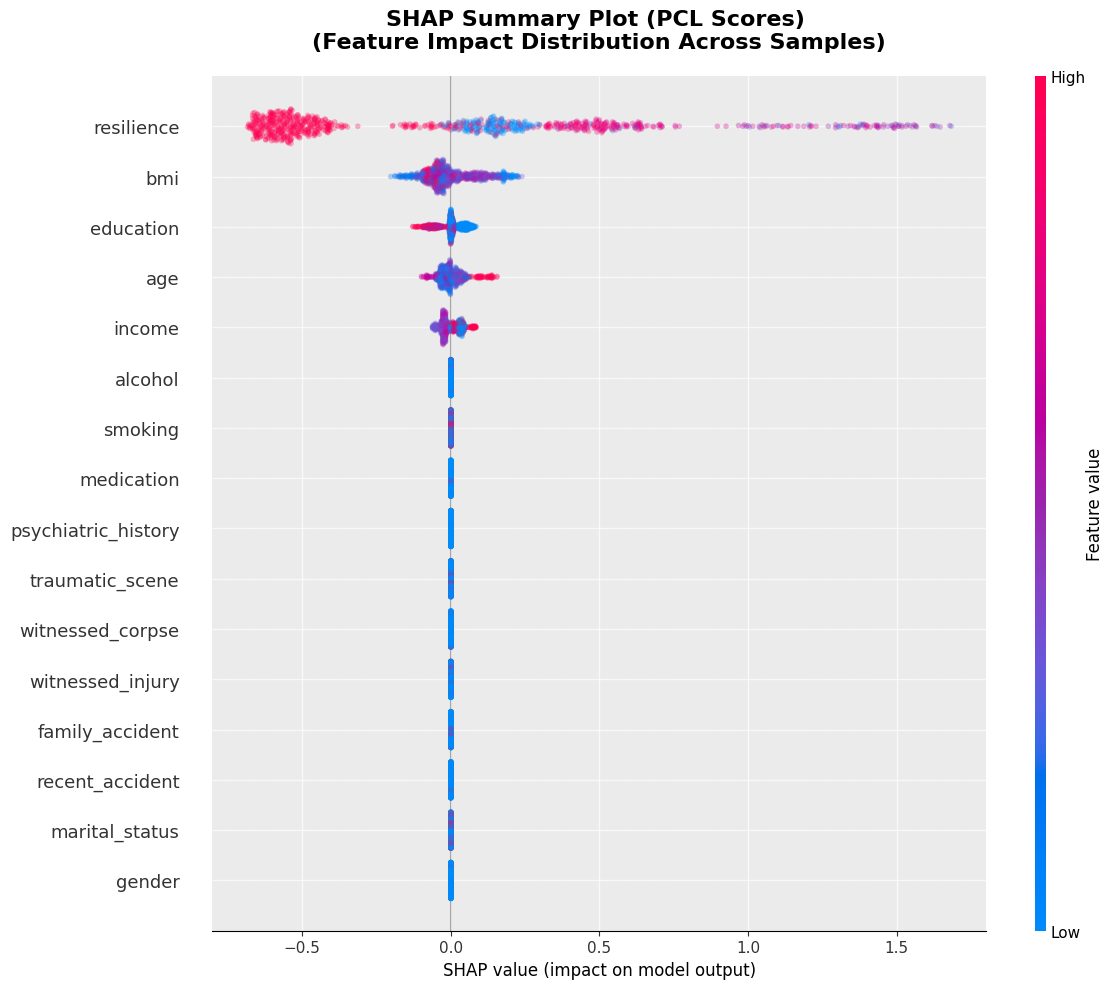

In [36]:
# 14. SHAP概要图 - 使用原始特征显示影响分布
import shap
import numpy as np
import matplotlib.pyplot as plt

# 使用之前计算的变量
rf_model = final_model.named_steps['regressor']
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_processed)

# 处理shap_values的格式
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# 关闭所有已存在的图形
plt.close('all')

# 改进的合并方法，更好地保持符号信息
def aggregate_shap_values_improved(shap_values, feature_mapping, original_feature_names):
    """
    改进的SHAP值合并方法
    """
    n_samples = shap_values.shape[0]
    n_features = len(original_feature_names)
    aggregated_shap = np.zeros((n_samples, n_features))
    
    for i, feature in enumerate(original_feature_names):
        if feature in feature_mapping:
            indices = feature_mapping[feature]
            if len(indices) == 1:
                # 单一特征直接复制
                aggregated_shap[:, i] = shap_values[:, indices[0]]
            else:
                # 多个特征（如one-hot编码）：计算净效应
                # 取绝对值最大的那个作为代表值，保持其符号
                feature_shap_values = shap_values[:, indices]
                abs_shap_values = np.abs(feature_shap_values)
                max_abs_indices = np.argmax(abs_shap_values, axis=1)
                
                # 为每个样本选择影响最大的那个one-hot特征的值
                for sample_idx in range(n_samples):
                    aggregated_shap[sample_idx, i] = feature_shap_values[sample_idx, max_abs_indices[sample_idx]]
    
    return aggregated_shap

# 合并SHAP值
aggregated_shap_values_improved = aggregate_shap_values_improved(
    shap_values, feature_mapping, original_feature_names
)

# 绘制使用原始特征的概要图 - 添加透明度和ggplot2样式背景
plt.figure(figsize=(12, 10))

# 创建SHAP概要图
shap.summary_plot(
    aggregated_shap_values_improved, 
    X.values, 
    feature_names=display_feature_names,
    show=False,
    plot_size=None,
    alpha=0.3  # 设置点的透明度为0.6
)

# 获取当前坐标轴并设置ggplot2样式
ax = plt.gca()

# 设置灰色背景，类似ggplot2默认样式
ax.set_facecolor('#EBEBEB')  # 浅灰色背景

# 添加网格线 - 类似ggplot2样式
ax.grid(True, color='white', linestyle='-', linewidth=1, alpha=0.7)
ax.set_axisbelow(True)  # 确保网格线在数据点下方

# 设置标题
ax.set_title('SHAP Summary Plot (PCL Scores) \n(Feature Impact Distribution Across Samples)', 
             fontsize=16, fontweight='bold', pad=20)

# 设置坐标轴标签样式
ax.set_xlabel(ax.get_xlabel(), fontsize=12)
ax.set_ylabel(ax.get_ylabel(), fontsize=12)

plt.tight_layout()
plt.savefig('shap_summary_plot_original_features.pdf', dpi=300, bbox_inches='tight', 
            facecolor='white')  # 设置保存时的背景色
plt.show()
plt.close()